In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fileinput
import glob
import os
import shutil
import random
import math
import random as random
random.seed(1)  # set random seed.
pd.set_option('display.max_columns', None)

In [69]:
#################################
#### FUNCTIONS USED LATER #######
#################################
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']
def get_first_line(file_path): #get first line 
    with open(file_path) as f:
        return f.readline()

def get_last_line(file_path): #faster way to get last line
    with open(file_path, 'rb') as file:
        try:
            file.seek(-2, os.SEEK_END)
            while file.read(1) != b'\n':
                file.seek(-2, os.SEEK_CUR)
        except OSError:
            file.seek(0)
        last_line = file.readline().decode()
        return last_line
def maybe_float(s):
    try:
        return float(s)
    except (ValueError, TypeError):
        return s

def Kepler_3rdLaw_SMA(m1,m2,SMA ): #M_sun and AU units, output in yr
    return np.power( ( (SMA**3)/(m1+m2) ) ,1./2.)

def Kepler_3rdLaw(P,m1,m2,SMA = 0,output='a'):

    '''
    Function to get semi-major axis from period using K3L
    :param P: Period of orbit in **yr**
    :return: returns SMA (a) in **AU**
    '''
    G = 1.19e-19 #G in AU^3/M_sun*s^2
    if output == 'a':
        return np.power( ( (P**2)*(m1+m2) ) ,1./3.) #Kepler's Third Law
    elif output=='p' or output=='P' : 
        return np.power( ( (SMA**3)/(m1+m2) ) ,1./2.)
def Roche_limit(q):
    '''
    Function to get Roche Limit of specified mass ratios (q)
    :param q: mass ratio
    :return: returns the Roche Limit (RHS of Eqn.1 from Naoz+2014)
    '''
    num1,num2=0.49,0.6;
    return num1*np.power(q,2./3.)/(0.6* np.power(q,2./3.)+np.log(1+np.sqrt(q)));
def pos_normal(mean, sigma): 
    '''
    Function to get only positive values from normal distribution recursively
    '''
    x = np.random.normal(mean,sigma)
    return (x if x>=0 else pos_normal(mean,sigma))

def random_normal_bounds(mean, sigma, lower, upper):
    val = np.random.normal(mean,sigma)
    if lower<val<upper:
        return val
    else:
        return random_normal_bounds(mean, sigma, upper, lower)

def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g) 
 
def miller_scalo_IMF(arr,lower=1.0,upper=8.0):

    if 0.1<arr<=1: return rndm(0.1,1.0,-0.25)[0]
    if 1.<arr<=2.: return rndm(1.0,2.0,-1.00)[0]
    if 2.<arr<=10: return rndm(2.0,8.0,-1.30)[0]
    if 10<arr<=25: return rndm(10.0,125.0,-2.30)[0]

def kroupa_IMF(arr,lower=0.08,upper=8.0):

    #if arr<0.08: return rndm(0.1,1.0,0.7)[0]
    if 0.08<=arr<0.5: return rndm(0.08,0.5,-0.3)[0]
    if 0.5<=arr<8: 
        if lower > 0.5:
            return rndm(lower,upper,-1.30)[0]
        else:
            return rndm(0.5,upper,-1.30)[0]


def sampleFromSalpeter(M_min : int, M_max : int,N :int = 1,alpha : float = 2.35):
    """Sample from a Salpeter, but can be used for any power law

    Args:
        M_min (int): lower bound of mass interval
        M_max (int): upper bound of mass interval
        N (int, optional): number of samples. Defaults to 1.
        alpha (float, optional): power-law index. Defaults to 2.35 for Salpeter.

    Returns:
        float: if you only wanted one sample
        list:  if you wanted multiple samples
    """
    
    # Convert limits from M to logM.
    log_M_Min = math.log(M_min)
    log_M_Max = math.log(M_max)
    # Since Salpeter SMF decays, maximum likelihood occurs at M_min
    maxlik = math.pow(M_min, 1.0 - alpha)

    # Prepare array for output masses.
    Masses = []
    # Fill in array.
    while (len(Masses) < N):
        # Draw candidate from logM interval.
        logM = random.uniform(log_M_Min,log_M_Max)
        M    = math.exp(logM)
        # Compute likelihood of candidate from Salpeter SMF.
        likelihood = math.pow(M, 1.0 - alpha)
        # Accept randomly.
        u = random.uniform(0.0,maxlik)
        if (u < likelihood):
            Masses.append(M)
            
    return Masses if len(Masses) > 1 else Masses[0]

Rsun = (695500*6.68459e-9)  #sun radius in AU

# def vectorize_initialize_IMF(IMF_function):
#     MS_IMF_gen = np.vectorize(lambda arr: miller_scalo_IMF(arr)) #vectorize the function
#     x = np.linspace(1,8,int(1e5))
#     MS_IMF_samples = MS_IMF_gen(x)
#     n_MS, bins_MS, patches = plt.hist(MS_IMF_samples,bins=500,cumulative=True,density=True,histtype='step') 
#     plt.clf()
#Setup for the MS IMF
# MS_IMF_gen = np.vectorize(lambda arr: miller_scalo_IMF(arr)) #vectorize the function
# x = np.linspace(1,8,int(1e5))
# MS_IMF_samples = MS_IMF_gen(x)
# n_MS, bins_MS, patches = plt.hist(MS_IMF_samples,bins=500,cumulative=True,density=True,histtype='step') 
# plt.clf()

Kroupa_IMF_gen1 = np.vectorize(lambda arr: kroupa_IMF(arr,lower=0.8)) #vectorize the function
Kroupa_IMF_gen2 = np.vectorize(lambda arr: kroupa_IMF(arr,lower=0.08)) #vectorize the function
x1= np.linspace(0.8,8.0,int(1e6))
x2 = np.linspace(0.08,8.0,int(1e6))
Kroupa_IMF_samples1 = Kroupa_IMF_gen1(x1)
Kroupa_IMF_samples2 = Kroupa_IMF_gen2(x2)

n_Kroupa1, bins_Kroupa1, patches1 = plt.hist(Kroupa_IMF_samples1,bins=5000,cumulative=True,density=True,histtype='step') 
n_Kroupa2, bins_Kroupa2, patches2 = plt.hist(Kroupa_IMF_samples2,bins=5000,cumulative=True,density=True,histtype='step') 
plt.clf()


<Figure size 640x480 with 0 Axes>

(array([1.62501173, 1.66737315, 1.70348452, ..., 0.00763894, 0.00694449,
        0.00972229]),
 array([0.80000005, 0.80144004, 0.80288003, ..., 7.9970753 , 7.99851529,
        7.99995528]),
 [<matplotlib.patches.Polygon at 0x1288c8550>])

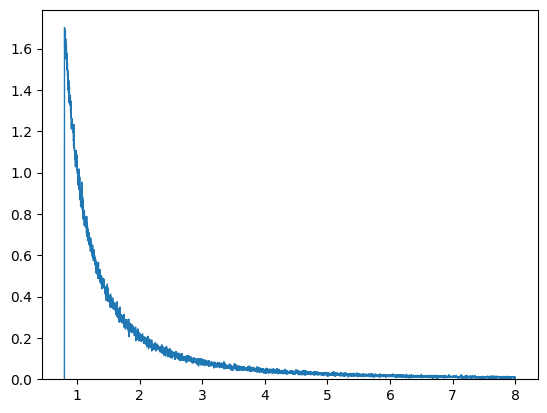

In [6]:
plt.hist(Kroupa_IMF_samples1,bins=5000,cumulative=False,density=True,histtype='step') 

In [88]:
# BOOLEANS to check that parameters are **STABLE**
def get_all_criteria(a1,a2,e1,e2,m1,m2,m3,R1,R2,i,q_out):
    #stability_criteria from Mardling & Aarseth (2001),**BOOL**
    stable = 2.8 * np.power(1.+ q_out,2./5.) * np.power(1.+e2, 2./5.)*np.power(1.-e2, -6./5.)*(1-(0.3*i/180.)) 
    epsilon = (a1/a2) * e2 / (1-e2**2) #epsilon criterion from Naoz+2014
    
    Roche1=Roche_limit(m1/m2)
    Roche2=Roche_limit(m2/m1)

    stability_criteria = (a2/a1) > stable
    epsilon_criteria = epsilon < 0.1
    Roche1_criteria = R1*Rsun < (a1*(1-e1)*Roche1)
    Roche2_criteria = R2*Rsun < (a1*(1-e1)*Roche2)
    mass_criteria =  True #m1>0 and m2>0 and m3>0 #this condition should already be met bc pos_normal function
    
    all_criteria = (stability_criteria and mass_criteria and epsilon_criteria and (Roche1_criteria and Roche2_criteria) )
    
    return all_criteria

from numpy.random import random as rndm
from scipy import interpolate
import cProfile


def f(x, which_one = 'linear'):
    # does not need to be normalized
    if which_one == 'linear':
        1 - 0.5*x
    #return 1 - 0.5*x #np.exp(-x**2) * np.cos(3*x)**2 * (x-1)**4/np.cosh(1*x)

def sample(g):
    x = np.linspace(0,1,100000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x, fill_value="extrapolate")    # this is a function
    return inverse_cdf

def return_samples(N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples  = rndm(int(N))
    required_samples = sample(f)(uniform_samples)
    return required_samples

# cProfile.run('return_samples()')


In [105]:
def initial_conditions(IMF : str = '1', both_masses : bool = False, IMRD = 'DM91'): 
    IMF_chosen  = IMF
    IMRD_chosen = IMRD
    if IMF == '1': 
        m1=1. #default m1= 1 M_sun
    elif IMF == 'Salpeter': 
        m1 = sampleFromSalpeter(1.00, 8.)  #Salpeter PDF #or 1
    elif IMF == 'MS': 
        m1 = random.choices(bins_MS[:-1], cum_weights = n_MS)[0]
    elif IMF == 'Kroupa': 
        m1 = random.choices(bins_Kroupa1[:-1], cum_weights = n_Kroupa1)[0]
    
    if IMRD == 'DM91':
        q_in  = pos_normal(0.23,0.42)
        q_out = pos_normal(0.23,0.42)
    elif IMRD == 'linear':
        q_in  = return_samples(1)[0]
        q_out = return_samples(1)[0]
    elif IMRD == 'uniform':
        q_in  = np.random.uniform(0,1,1)[0]
        q_out = np.random.uniform(0,1,1)[0] 
    
        
    m2 =  q_in * m1        #random.choices(bins_Kroupa1[:-1], cum_weights = n_Kroupa1)[0]        #sampleFromSalpeter(1.00, 8.) 
    m3 =  q_out*(m1+m2)    #random.choices(bins_Kroupa2[:-1], cum_weights = n_Kroupa2)[0]    #1e-4 #random.choices(bins_Kroupa[:-1], cum_weights = n_Kroupa)[0] #q_out*(m1+m2)
    
    R1 = m1
    R2 = R1*np.power(m2/m1,4./5.)
    
    spin1P = 25.
    spin2P = 25.
    
    beta = np.random.uniform(0,180)
    beta2 = 0.
    
    gamma = 45.
    gamma2 = 45.
    
    g1 = np.random.uniform(0,360)
    g2 = np.random.uniform(0,360)
    
    age = 10*1e3 #*1.e6, means 10*1e9

    mu,sigma = 4.8, 2.3 #From Frabycky and Tremaine

    P_in,P_out = 10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma) #periods in days #10**np.random.normal(4.8,2.3)
    P_in,P_out = P_in/365.25, P_out/365.25 #periods in yr
    
    a1,a2 = Kepler_3rdLaw(P_in,m1,m2), Kepler_3rdLaw(P_out,m1+m2,m3) #10**np.random.normal(mu,sigma), 10**np.random.normal(mu,sigma)        #Kepler_3rdLaw(P_in,m1,m2), 1e6#Kepler_3rdLaw(P_out,m1+m2,m3) #SMA in AU
    e1,e2 = np.random.uniform(0,1),np.random.uniform(0,1)

    #inclination
    cosi = np.random.uniform(np.cos(0),np.cos(np.pi))
    i = np.rad2deg(np.arccos(cosi))

    Rsun = (695500*6.68459e-9)  #sun radius in AU

    criteria = get_all_criteria(a1,a2,e1,e2,m1=m1,m2=m2,m3=m3,R1=R1,R2=R2,i=i,q_out=q_out)
    # want to keep sampling a1 until criteria are met
    n=0
    while not criteria and n < 100:
        n+=1
        a1 = 10**random_normal_bounds(mu,sigma,-2,6)
        criteria = get_all_criteria(a1,a2,e1,e2,m1=m1,m2=m2,m3=m3,R1=R1,R2=R2,i=i,q_out=q_out) #get criteria with new a
    # recurse if criteria are not met until criteria are met
    if criteria:
        params = np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age])
        return params
    else:
        return initial_conditions(IMF = IMF_chosen, IMRD = IMRD_chosen)
    

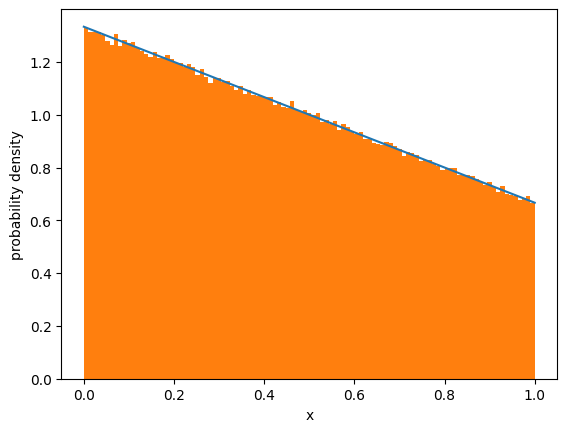

In [92]:
## plot
x = np.linspace(0,1,10000)
fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,f(x)/np.sum(f(x)*(x[1]-x[0])) )
ax.hist(return_samples(1000000),bins='auto',density=True,range=(x.min(),x.max()))
plt.show() 

In [ ]:
m1s,m2s,m3s,a1s,a2s = [],[],[],[],[]
for _ in range(10000):
    m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age = initial_conditions(IMF = '1',IMRD='linear')
    m1s.append(m1),m2s.append(m2),m3s.append(m3)
    a1s.append(a1),a2s.append(a2)


(array([1.26928656, 1.29057033, 1.28863544, 1.28476566, 1.30411454,
        1.23832835, 1.1164304 , 1.02355578, 1.10288619, 1.01388134,
        0.94422537, 0.96744402, 0.88617873, 0.81458787, 0.80104365,
        0.72558302, 0.65592705, 0.67334104, 0.55724776, 0.24186101,
        0.04643731, 0.02515354, 0.02708843, 0.02128377, 0.00967444,
        0.00773955, 0.00386978, 0.00193489, 0.00193489, 0.00386978]),
 array([1.15392295e-04, 5.17979690e-02, 1.03480546e-01, 1.55163122e-01,
        2.06845699e-01, 2.58528276e-01, 3.10210853e-01, 3.61893429e-01,
        4.13576006e-01, 4.65258583e-01, 5.16941159e-01, 5.68623736e-01,
        6.20306313e-01, 6.71988890e-01, 7.23671466e-01, 7.75354043e-01,
        8.27036620e-01, 8.78719197e-01, 9.30401773e-01, 9.82084350e-01,
        1.03376693e+00, 1.08544950e+00, 1.13713208e+00, 1.18881466e+00,
        1.24049723e+00, 1.29217981e+00, 1.34386239e+00, 1.39554496e+00,
        1.44722754e+00, 1.49891012e+00, 1.55059269e+00]),
 <BarContainer object of 30 

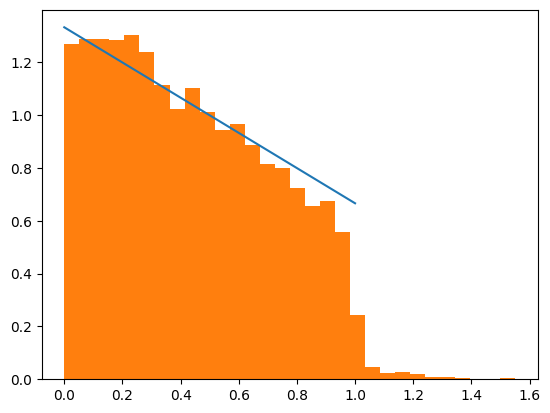

In [ ]:

x = np.linspace(0,1,10000)
plt.plot(x,f(x)/np.sum(f(x)*(x[1]-x[0])) )
plt.hist(np.array(m2s)/np.array(m1s),bins=30,density=True)


mean: 2.3 
 SD: 2.0


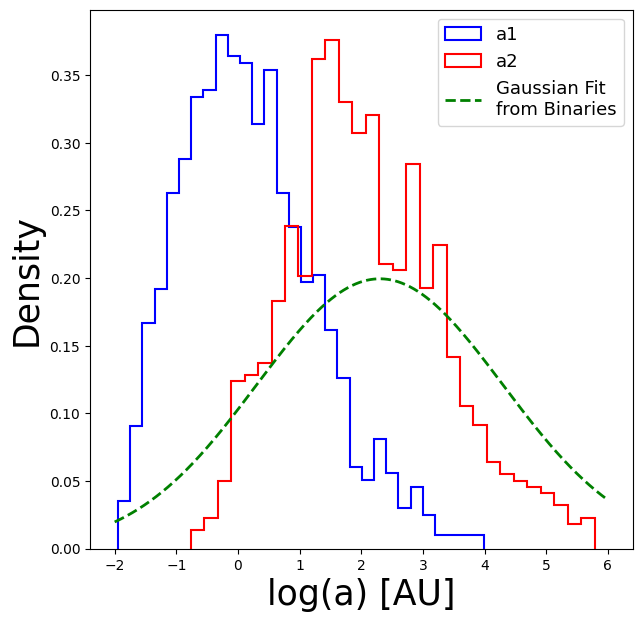

In [506]:
from scipy.stats import norm
import matplotlib.mlab as mlab

m1s,m2s,m3s,a1s,a2s = [],[],[],[],[]
for _ in range(1000):
    m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age = initial_conditions(IMF = '1',IMRD='linear')
    m1s.append(m1),m2s.append(m2),m3s.append(m3)
    a1s.append(a1),a2s.append(a2)


# add a 'best fit' line


fig,(ax2) = plt.subplots(figsize=(7,7))
#ax1.hist(m1s,color='b',label='m1', histtype='step',linewidth=1.5,density=True)
# ax1.axvline(1,color='b')
# ax1.hist(m2s,color='r',label='m2', histtype='step',linewidth=1.5,density=True)

y1 = a1s#Kepler_3rdLaw_SMA( np.array(m1s), np.array(m2s), np.array(a1s)) #Periods
y2 = a2s#Kepler_3rdLaw_SMA( np.array(m1s) + np.array(m2s), np.array(m3s), np.array(a2s)) #Periods

ax2.hist(np.log10(y1),color='b',label='a1', histtype='step',linewidth=1.5,density=True,bins=30)
ax2.hist(np.log10(y2),color='r',label='a2', histtype='step',linewidth=1.5,density=True,bins=30)

(mu, sigma) = 2.3, 2.0  #norm.fit(np.log10(y2))
x = np.linspace(-2,6,1000)

ax2.plot(x, norm.pdf(x, mu, sigma), 'g--', linewidth=2,label='Gaussian Fit\nfrom Binaries')
print(f"mean: {mu} \n SD: {sigma}")

# ax1.set_xlabel('Mass'), ax1.set_ylabel('Density')
ax2.set_xlabel('log(a) [AU]',fontsize=25), ax2.set_ylabel('Density',fontsize=25)

ax2.legend(fontsize=13,loc=1)

plt.show()

In [5]:
#############################################
##### FUNCTIONs THAT CREATES triple.in's #####
#############################################

#OSPE FLAGS; 0 (yes) 1 (no)
quadrupole = 0
octupole = 0
GR = 0
TF = 0
ML1 = 0
MB1 = 0
ML2 = 0
MB2 = 0
ML3 = 0
SSE1 = 0
SSE2 = 0
SSE3 = 0
tMSMyr = 0

# ==========================================================================

def create_file(initial_conditions, file_dir, file_end, eps = 1e-16, restart=False):
    """
    Function to create a triple.in file with input initial conditions
    :param initial_conditions: array of initial conditions from generate_inicon
    :param file_dir: directory to store triple.in files in
    :param file_end: file suffix (i.e. '1' to write triple.in1)
    :param start_time: system age to start simulations on
    :param restart: flag set to True if code is being re-started on Hoffman
    :return: writes a triple.inX file and saves to file_dir
    """
    # open new file
    filename = file_dir + '/' + 'triple.in' + file_end
    out = open(filename,'w')
    
    # write header
    out.write("#########################################################################\n")
    out.write("## Read in the initial orbital parameters of the triple system         ##\n")
    out.write("## Mass in M_sol, semimajor axis in AU                                 ##\n")
    out.write("#########################################################################\n")
    out.write("\n")
    
    if restart==False:
        out.write("__m1_______m2___________m3________R1(Rsun)____R2(Rsun)____Spin1P(day)__Spin2P(day)_ _beta(s_O_deg)__beta2(s_O_deg)__gamma(s_O_deg)__gamma2(s_O_deg)__a1______a2____e1____e2____g1(deg)__g2(deg)__i(deg)__age(Myr)___ :::\n")
    
    elif restart==True:
        out.write("__m1_______m2___________m3________R1(Rsun)____R2(Rsun)____Spin1P(day)__Spin2P(day)_    _beta(s_O_deg)__beta2(s_O_deg)__gamma(s_O_deg)__gamma2(s_O_deg)__a1______a2____e1____e2____g1(deg)__g2(deg)__i(deg)__t_i(yr)__age(Myr)___ :::\n")
        
    out.write("\n")
    
    # add initial conditions
    out.write('  '.join([str(i) for i in initial_conditions])+'\n')
    
    # add header for flags
    out.write("\n")
    out.write("#########################################################################\n")
    out.write("## Flags                                                               ##\n")
    
    # quadrupole
    out.write("#########################################################################\n")
    out.write("\n")
    out.write("__QUADRUPOLE(0_yes_1_no)___ :::\n")
    out.write(str(quadrupole)+'\n') # for quadrupole?
    out.write("\n")
    
    # octupole
    out.write("#########################################################################\n")
    out.write("__OCTUPOLE(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(octupole)+'\n') # for octupole?
    out.write("\n")
    
    # GR
    out.write("#########################################################################\n")
    out.write("__GR(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(GR)+'\n') # for GR?
    out.write("\n")
    
    # tidal forces
    out.write("#########################################################################\n")
    out.write("__TF(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(TF)+'\n') #for TF?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML1)+'\n') # for ML1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__MB1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(MB1)+'\n') # for MB1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML2)+'\n') # for ML2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__MB2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(MB2)+'\n') # for MB2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__ML3(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(ML3)+'\n') # for ML3?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE1(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE1)+'\n') # for SSE1?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE2(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE2)+'\n') # for SSE2?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__SSE3(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(SSE3)+'\n') # for SSE3?
    out.write("\n")
    
    out.write("########################################################################\n")
    out.write("__tMSMyr(0_yes_1_no)___ :::\n")
    out.write("\n")
    out.write(str(tMSMyr)+'\n') # for tMSMyr?
    out.write("\n")
    
    # add control parameters section
    out.write("#########################################################################\n")
    out.write("## Control Parameters                                                  ##\n")
    out.write("#########################################################################\n")
    out.write("\n")
    out.write("__eps___ :::\n")
    out.write(str(eps)+"\n")
 #   out.write("1e-16\n")
    
    out.close()

    
############################################################
##### FUNCTION THAT CREATES N triple.in's TO DIRECTORY #####
############################################################
def generate_set_of_files(n, file_dir, start = 1, IMF = '1', both_masses=False):
    """
    Creates a set of triple.in files by iteratively running create_file()
    :param n: number of triple.in files to generate (will create triple.in1-n)
    :param file_dir: directory to store triple.in files in
    :return: writes a n triple.inX file and saves to file_dir
    """
    # for j in range(start,start+n+1):
    #     inicons = initial_conditions()
    #     file_end = str(j)
    #     print(initial_conditions)
    #     create_file(inicons, file_dir,file_end)
    this_IMF = IMF
    n_files = start
    n_max = start + n
    for_both = both_masses
    while n_files < n_max:
        inicons = initial_conditions(IMF = this_IMF,both_masses=for_both)
        
        file_end = str(n_files)
        create_file(inicons, file_dir, file_end)
        n_files += 1

In [560]:
# ==========================================================================
# RUNNING THE ABOVE FUNCTIONS TO GENERATE FILES 
a = input('Are you sure that you want to continue? [y/n]: ')
if a == 'y' or a == 'Y':
    n=1000
    file_dir='/Users/bijan1339/Desktop/Research/ICs/'
    generate_set_of_files(n,file_dir,start=1000, IMF = 'Kroupa', both_masses=True)

In [276]:
file_path = '/Users/bijan1339/Desktop/Research/Final_Output6/output_6419.txt'
with open(file_path) as f:
        lines = f.readlines()[0:-5]

In [6]:
#iterate through triple.in path and store parameters
triple_dir = '/Users/bijan1339/Desktop/Research/ICs/'
def get_initial_parameters(start=0,stop=999, triple_dir = '/Users/bijan1339/Desktop/Research/ICs/'):
    
    m1s,m2s,m3s=[],[],[]
    a1s,a2s,e1s,e2s = [],[],[],[]
    for filename in sorted(os.listdir(triple_dir)):
        this_file = os.path.join(triple_dir, filename)
        if filename.split('.')[0] != 'triple': continue
                
        n=int(filename.split('.in')[-1])
        
        if not start <= n <= stop: continue
        
        with open(this_file) as f:
                params = f.readlines()[7].split('  ') #params on seventh line of file
                params = [maybe_float(x) for x in params]
                m1,m2,m3 = params[0:3]
                a1,a2,e1,e2 = params[-8:-4]
                
                # m1,m2,m3 = initial_conditions(IMF='Salpeter')[0:3]
                # a1,a2,e1,e2 = initial_conditions(IMF='Salpeter')[-8:-4]
        
                m1s.append(m1),m2s.append(m2),m3s.append(m3)
                a1s.append(a1),a2s.append(a2),e1s.append(e1),e2s.append(e2)
                        
    return m1s,m2s,m3s,a1s,a2s,e1s,e2s



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


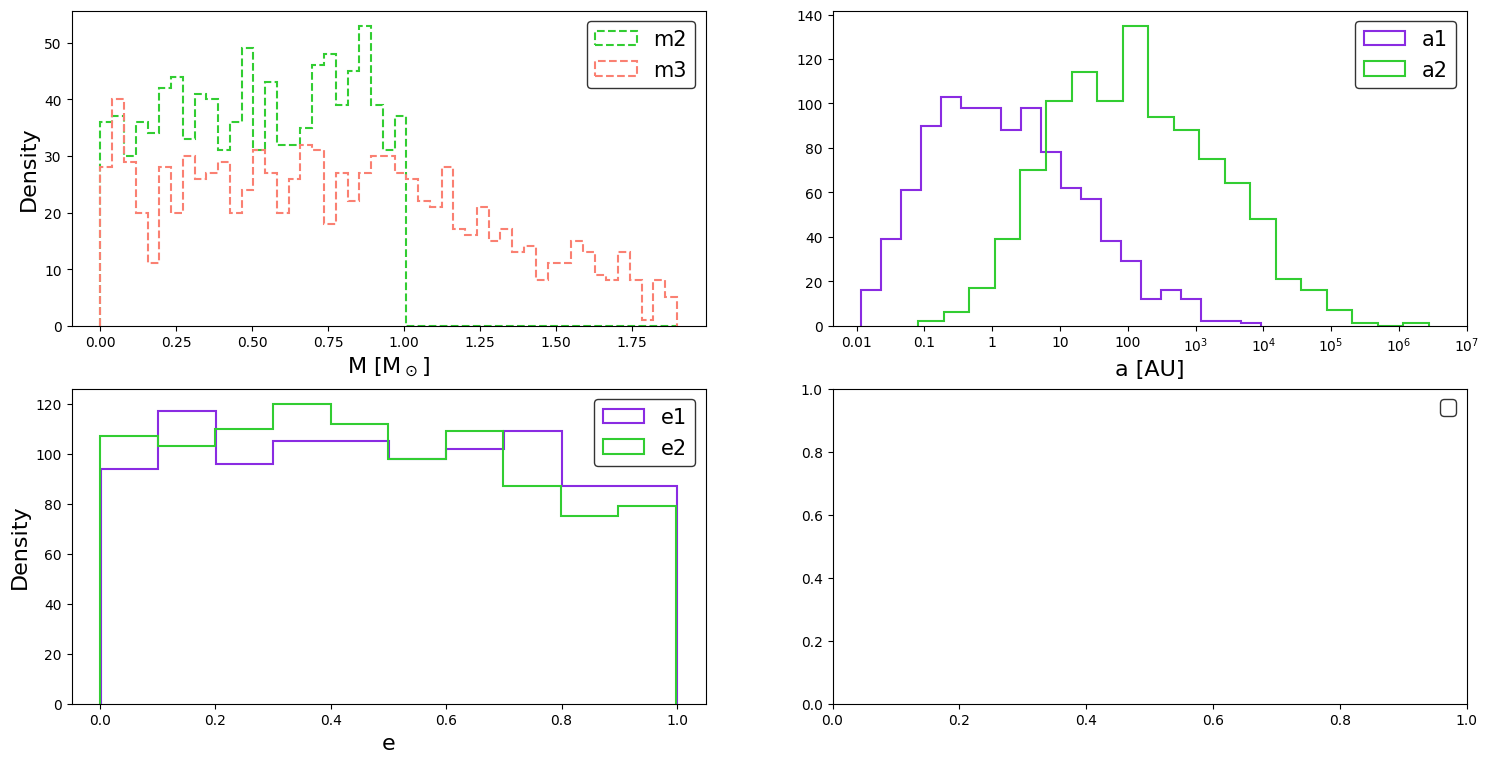

In [106]:
import random
def get_log_bins(arr,n_bins=10):
    return np.logspace( np.log10(np.min(arr)),np.log10(np.max(arr)), n_bins, base=10)

#m1s,m2s,m3s,a1s,a2s,e1s,e2s = get_initial_parameters(start=0,stop=999, triple_dir = '/Users/bijan1339/Desktop/Research/ICs/')
m1s,m2s,m3s=[],[],[]
a1s,a2s=[],[]
e1s,e2s=[],[]
for _ in range(1000):
    m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,age = initial_conditions(IMF='1',IMRD = 'uniform')
    m1s.append(m1), m2s.append(m2), m3s.append(m3)
    a1s.append(a1), a2s.append(a2)
    e1s.append(e1), e2s.append(e2)
    
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 9))

bins_m = np.linspace( np.min(np.concatenate((m1s,m2s,m3s))) , np.max(np.concatenate((m1s,m2s,m3s))) ,  50)
bins_a1 = get_log_bins(a1s,n_bins=40)
bins_a2 = get_log_bins(a2s,n_bins=40)

kwargs_hist = {'histtype' :'step','linewidth':1.5,'density':False}
c1, c2, c3,c4 = 'blueviolet','deepskyblue','salmon','limegreen'


# ax1.hist(m1s,color=c1,label='m1',bins=bins_m,**kwargs_hist)
ax1.hist(m2s,color=c4,label='m2',bins=bins_m,linestyle='--', **kwargs_hist)
ax1.hist(m3s,color=c3,label='m3',bins=bins_m,linestyle='--', **kwargs_hist)

ax2.hist(np.log10(a1s),color=c1,label='a1',bins=20,**kwargs_hist)
ax2.hist(np.log10(a2s),color=c4,label='a2',bins=20,**kwargs_hist)

ax3.hist(e1s,color=c1,label='e1',**kwargs_hist)
ax3.hist(e2s,color=c4,label='e2', **kwargs_hist)

ax1.legend(fontsize=15,edgecolor='k'), ax2.legend(fontsize=15,edgecolor='k'), ax3.legend(fontsize=15,edgecolor='k'), ax4.legend(fontsize=15,edgecolor='k')

ax1.set_xlabel('M [M$_\odot$]',fontsize=16),ax2.set_xlabel('a [AU]',fontsize=16), ax3.set_xlabel('e',fontsize=16)
ax1.set_ylabel('Density',fontsize=16), ax3.set_ylabel('Density',fontsize=16)
#ax1.axvline(1.,color='k')

#ax2.set_xscale('log')
ax2.set_xticks([-2,-1,0,1,2,3,4,5,6,7],['0.01','0.1', '1','10','100','10$^3$','10$^4$','10$^5$','10$^6$','10$^7$'])
plt.show()

## Run with new restrictions on initial SMA
## 450 for 1T and 450 for KT

In [151]:
k = sampleFromSalpeter(100000, 2.35, 0.08, 8.)

(0.0, 2.0)

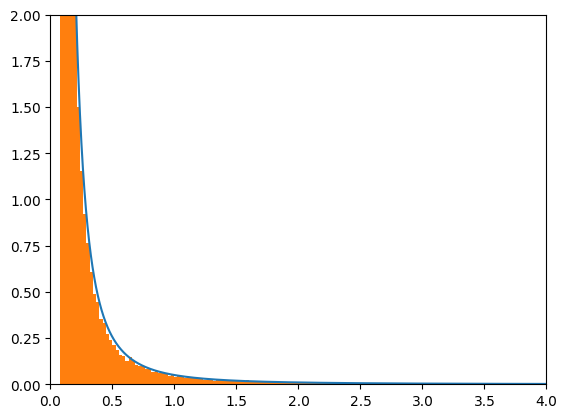

In [154]:
x = np.linspace(0.08,8.,10000)
N=0.05
y = N*x**-2.35
plt.plot(x,y)
plt.hist(k,bins=300,density=True)
plt.xlim(0,4)
plt.ylim(0,2)

In [343]:
with open('/Users/bijan1339/Desktop/Research/zneed_to_del.txt') as f:
        lines = f.readlines()
nums=[]
for l in lines:
        nums.append( l.split(" ")[3] )
        

In [344]:
print( ' '.join(nums) )

5926425 5926426 5926427 5926428 5926429 5926430 5926432 5926433 5926434 5926436 5926437 5926438 5926439 5926440 5926441 5926442 5926443 5926444 5926445 5926446 5926447 5926448 5926449 5926450 5926451 5926452 5926453 5926454 5926455 5926456 5926457 5926458 5926459 5926460 5926461 5926462 5926463 5926464 5926466 5926467 5926468 5926470 5926473 5926474 5926475 5926476 5926477 5926478 5926479 5926480 5926481 5926482 5926483 5926484 5926485 5926486 5926487 5926488 5926489 5926490 5926491 5926492 5926493 5926494 5926495 5926496 5926497 5926498 5926499 5926500 5926501 5926502 5926504 5926506 5926507 5926508 5926509 5926510 5926511 5926512 5926513 5926514 5926515 5926516 5926517 5926518 5926519 5926520 5926521 5926522 5926523 5926524 5926525 5926526 5926527 5926528 5926529 5926530 5926531 5926532 5926533 5926535 5926536 5926538 5926540 5926541 5926542 5926543 5926544 5926545 5926546 5926547 5926548


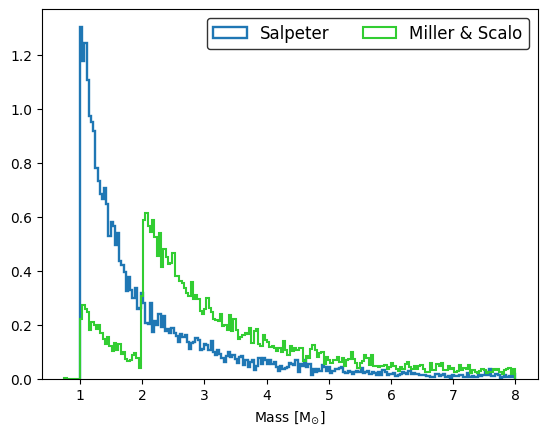

In [274]:
#SALPETER IMF
c=[]
MS=[]
x = np.linspace(1,8,10000)
MS_IMF_samples = MS_IMF_gen(x)
y= 1.4*x**-2.35
for i in range(10000):
    c.append(rndm(1.0,8.0,-1.35)[0])
    
plt.hist(c,histtype='step',bins=200,linewidth=1.7,density=True,label = 'Salpeter')
plt.hist(MS_IMF_samples,histtype='step',density=True,bins=200,linewidth=1.5,color='limegreen',label='Miller & Scalo')

#plt.plot(x,y,c='r')
plt.xlabel('Mass [M$_{\odot}$]')
plt.legend(edgecolor='k',fontsize=12,ncol=2)


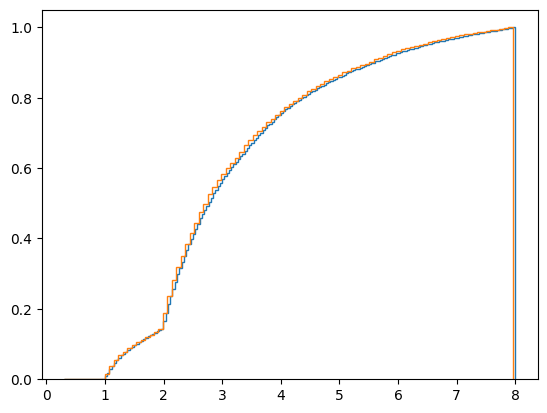

In [254]:
n, bins, patches = plt.hist(MS_IMF_samples,bins=200,cumulative=True,density=True,histtype='step')

import random
x = [random.choices(bins[:-1], cum_weights = n)[0] for x in range(10000)]

plt.hist(x,cumulative=True,histtype='step',density=True,bins=100)
plt.show()


# Make Restart Input Files

In [267]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']


AU = 1.496E13       # astronomical unit, cm 
Rsun = 6.96e10    # radius of sun, cm 
pi = np.pi          # pi, 


inicon_dir = '/Users/bijan1339/Desktop/Research/ICs/' #directory of where triple.in's are
zero_dir = '/Users/bijan1339/Desktop/Research/ICs_Zero/' #for files that didn't start (t=0 or filesize=0), just need to rerun these, no restart
restart_inicon_dir = '/Users/bijan1339/Desktop/Research/ICs_restart' #where to put new restart triple.in's 

#CHANGE THESE
outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output8/' #'/Users/bijan1339/Desktop/Research/Outputs/'
start, stop = 8000, 9000

#FIND RESTART FILES THAT ARE STILL GOING
filename = '/Users/bijan1339/Desktop/Research/StillGoing.txt'
with open(filename) as file:
    lines = file.readlines()
still_going_n = [int(x.split(' ')[5].split('OSPE_')[-1][:-1]) for x in lines]

alr_finished_n = []

never_started=[]
never_started_restart=[]
restart_numbers=[]
all_n=[]
memory_errors=[]
cass_n=[]
x=0

for filename in os.listdir(outputs_directory):
    x+=1
    needs_restart=False
    is_me = False
    
    n = filename.split('_')[-1].split('.')[0]
    if type(maybe_float(n)) is not float:
        continue
    if (
        (filename.endswith('.txt') and filename.startswith('output_') ) and 
        (start <= int(n) <= stop)
        ):
        
        all_n.append(n)
        n = int(n) #output_n.txt
        
        this_file = os.path.join(outputs_directory, filename) #stores FULL filename

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]

        if os.stat(this_file).st_size == 0.:
            memory_errors.append(n)
            is_me = True
        elif ( 
            float(last_line[2]) == 0. and (float(last_line[0]) != 0. and float(last_line[0]) != 4.)
              ) : #last condiition is to check if it was a merger
                #shutil.copy(source,destination)
                shutil.copy(inicon_dir+'triple.in'+str(n), 
                            zero_dir+'triple.in'+str(n) )
                never_started.append(n)
                if n not in still_going_n: needs_restart = True

        if (last_line[-1] != 'END') and (not is_me) and (n not in alr_finished_n):# and float(last_line[2]) <=1e10:# and ( (float(last_line[0]) != 0.) or (float(last_line[0]) != 4.)):
            # if e1 > 0.05 and a1 > 0.2:
            #     restart_numbers.append(n)
            # read in parameters from output file
            ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    

            end_time = fp[2] # last time printout of simulation
            
            total_age = 12.5e9
            age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
            e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]
            g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])
            m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses
            R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert from AU to Rsun
            beta2,gamma,gamma2 = fp[32], fp[33],fp[34]
            P_out = Kepler_3rdLaw_SMA(m1+m2,m3,a2 )  # in yr 
            time_remain = total_age - end_time
            # compute spins from output
            spin1h, spin1e, spin1q = fp[11], fp[15], fp[16]
            spin2h, spin2e, spin2q = fp[19], fp[17], fp[18]
            spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
            spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
            spin1P = 2.*pi*365.25/spin1P_radyr
            spin2P = 2.*pi*365.25/spin2P_radyr

            final_conditions = np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,end_time,age])
            if (e1 > 0.05) and (a1 > 0.2) and (P_out < time_remain):
                restart_numbers.append(n)
                create_file(final_conditions, restart_inicon_dir, str(n), restart=True) #create the restart triple.in file

        # else: 
        #     if int(last_line[0]) == 7: cass_n.append(int(n))
    

In [179]:
time_remain

12411171432.317968

In [271]:
print(sorted(restart_numbers)[:])

[8010, 8020, 8028, 8034, 8049, 8057, 8080, 8084, 8088, 8093, 8100, 8105, 8107, 8109, 8119, 8125, 8131, 8132, 8134, 8136, 8140, 8159, 8170, 8175, 8180, 8187, 8188, 8202, 8203, 8206, 8210, 8211, 8224, 8225, 8232, 8234, 8239, 8246, 8260, 8264, 8267, 8268, 8269, 8283, 8295, 8306, 8309, 8319, 8339, 8344, 8346, 8348, 8351, 8364, 8367, 8394, 8403, 8415, 8416, 8417, 8432, 8437, 8439, 8442, 8443, 8444, 8445, 8448, 8451, 8452, 8456, 8494, 8501, 8504, 8507, 8509, 8513, 8528, 8529, 8536, 8545, 8546, 8547, 8593, 8597, 8601, 8650, 8673, 8690, 8697, 8716, 8717, 8723, 8725, 8738, 8740, 8752, 8755, 8760, 8767, 8768, 8769, 8770, 8778, 8793, 8797, 8813, 8817, 8842, 8848, 8854, 8863, 8867, 8874, 8878, 8893, 8900, 8909, 8911, 8928, 8929, 8933, 8938, 8939, 8949, 8957, 8967, 8968, 8979, 8981, 8983, 8989, 8992, 8993, 8994, 8999]


# 
    - Read in unfinished final dataframes
    - Create new triple.in initial files
    - Write out list of of new, unfinished dataframes

In [154]:
columns[11]

'spin1h'

In [264]:
columns = ['sur', 'sur2', 't', 'e1','e2','g1','g2','a1','i1','i2','i','spin1h','spintot',
           'beta','vp','spin1e','spin1q','spin2e','spin2q','spin2h','htot','m1','R1','m2',
           'R2','a2','m3','Roche1','R1','type1','type2','type3','beta2','gamma','gamma2','flag']



inicon_dir = '/Users/bijan1339/Desktop/Research/ICs/' #directory of where triple.in's are
zero_dir = '/Users/bijan1339/Desktop/Research/ICs_Zero/' #for files that didn't start (t=0 or filesize=0), just need to rerun these, no restart
restart_inicon_dir = '/Users/bijan1339/Desktop/Research/ICs_restart' #where to put new restart triple.in's 
#unfinished_finalDFs_dir = '/Users/bijan1339/Desktop/Research/unf_dfs/' #final dfs that need restart, in pickle format

#READ in Dfs
pickle_PATH = '/Users/bijan1339/Desktop/Research/Dataframes/'
needs_RE0_f = pd.read_pickle(pickle_PATH + 'needs_RE0_f.pkl')  
needs_RE7_f = pd.read_pickle(pickle_PATH + 'needs_RE7_f.pkl')  
needs_RE1_f = pd.read_pickle(pickle_PATH + 'needs_RE1_f.pkl')  
needs_RE6_f = pd.read_pickle(pickle_PATH + 'needs_RE6_f.pkl')
  
needs_RE0_i = pd.read_pickle(pickle_PATH + 'needs_RE0_i.pkl')  
needs_RE7_i = pd.read_pickle(pickle_PATH + 'needs_RE7_i.pkl')  
needs_RE1_i = pd.read_pickle(pickle_PATH + 'needs_RE1_i.pkl')  
needs_RE6_i = pd.read_pickle(pickle_PATH + 'needs_RE6_i.pkl')  

#CHANGE THESE
outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output1/' 
start, stop = 1000, 2000

def get_params_for_restart(row,row_initial, outputs_dirNAME = 'Final_Output1' ):
    
    this_n = row['N']
    this_out_dir = f'/Users/bijan1339/Desktop/Research/{outputs_dirNAME}/'

    end_time = row['t']

    total_age = 12.5e9
    age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to

    e1,e2,a1,i,beta = row['e1'], row['e2'], row['a1'], row['i'], row['beta']
    g1, g2 = np.rad2deg(row['g1']), np.rad2deg(row['g2'])

    m1,m2,m3 = row_initial['m1'].tolist()[0], row_initial['m2'].tolist()[0], row_initial['m3'].tolist()[0] #taking the INITIAL, initial masses
    a2 = row['a2']
    R1, R2 = row['R1']*AU/Rsun, row['R2']*AU/Rsun # convert from AU to Rsun

    beta2,gamma,gamma2 = row['beta2'], row['gamma'], row['gamma2']

    # compute spins from output
    spin1h, spin1e, spin1q = row['spin1h'], row['spin1e'], row['spin1q']
    spin2h, spin2e, spin2q = row['spin2h'], row['spin2e'], row['spin2q']
    spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
    spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
    spin1P = 2.*pi*365.25/spin1P_radyr
    spin2P = 2.*pi*365.25/spin2P_radyr

    return (m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,end_time,age)
    
    
    
def entire_restart(needs_RE_I, needs_RE_F, model_no = '0', create = False,
                   restart_inicon_dir = '/Users/bijan1339/Desktop/Research/ICs_restart'):
    
    restart_numbers=[]
    
    for i,row in needs_RE_F.iterrows():
            
        this_N = row['N']
        this_initial_row = needs_RE_I[needs_RE_I['N'] == this_N]
                
        restart_numbers.append(this_N)
        """
        end_time = last['t'].tolist()[0]
        
        total_age = 12.5e9
        age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
        
        e1,e2,a1,i,beta = last['e1'].tolist()[0], last['e2'].tolist()[0], last['a1'].tolist()[0], last['i'].tolist()[0], last['beta'].tolist()[0]
        g1, g2 = np.rad2deg(last['g1'].tolist()[0]), np.rad2deg(last['g2'].tolist()[0])
        
        m1,m2,m3,a2 = first['m1'].tolist()[0], first['m2'].tolist()[0], first['m3'].tolist()[0], last['a2'].tolist()[0] #taking the INITIAL, initial masses
        R1, R2 = last['R1'].tolist()[0]*AU/Rsun, last['R2'].tolist()[0]*AU/Rsun # convert from AU to Rsun
        
        beta2,gamma,gamma2 = last['beta2'].tolist()[0], last['gamma'].tolist()[0], last['gamma2'].tolist()[0]

        # compute spins from output
        spin1h, spin1e, spin1q = last['spin1h'].tolist()[0], last['spin1e'].tolist()[0], last['spin1q'].tolist()[0]
        spin2h, spin2e, spin2q = last['spin2h'].tolist()[0], last['spin2e'].tolist()[0], last['spin2q'].tolist()[0]
        spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
        spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
        spin1P = 2.*pi*365.25/spin1P_radyr
        spin2P = 2.*pi*365.25/spin2P_radyr
        """

        these_params = get_params_for_restart(row = row,row_initial = this_initial_row, outputs_dirNAME = f'Final_Output{model_no}')
        
        m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,end_time,age = these_params
        
        final_conditions = np.array([m1,m2,m3,R1,R2,spin1P,spin2P,beta,beta2,gamma,gamma2,a1,a2,e1,e2,g1,g2,i,end_time,age])

        if create:
            create_file(final_conditions, restart_inicon_dir, str(this_N), restart=True) #create the restart triple.in file

            
    return restart_numbers
    

In [265]:
restart_no0 = entire_restart(needs_RE0_i, needs_RE0_f, model_no = '0', create = True)
restart_no7 = entire_restart(needs_RE7_i, needs_RE7_f, model_no = '7', create = True)
restart_no1 = entire_restart(needs_RE1_i, needs_RE1_f, model_no = '1', create = True)
restart_no6 = entire_restart(needs_RE6_i, needs_RE6_f, model_no = '6', create = True)

In [266]:
sum_of_all_restarts = len(restart_no0) + len(restart_no7) + len(restart_no1) + len(restart_no6)
print(f'0    : {len(restart_no0)}')
print(f'7    : {len(restart_no7)}')
print(f'1    : {len(restart_no1)}')
print(f'6    : {len(restart_no6)}')
print(f'Sum  : {sum_of_all_restarts}')
print('\n')

print(sorted(restart_no0))
print('\n')
print(sorted(restart_no7))
print('\n')
print(sorted(restart_no1))
print('\n')
print(sorted(restart_no6))

0    : 112
7    : 28
1    : 74
6    : 55
Sum  : 269


[3, 14, 15, 41, 56, 57, 59, 73, 77, 97, 98, 101, 112, 127, 134, 139, 147, 162, 165, 175, 187, 192, 208, 211, 214, 218, 229, 238, 244, 246, 255, 257, 262, 276, 284, 289, 308, 313, 315, 321, 327, 328, 329, 332, 335, 380, 391, 392, 399, 420, 421, 431, 444, 446, 454, 458, 499, 501, 527, 535, 539, 546, 555, 560, 565, 598, 601, 606, 616, 617, 626, 627, 630, 660, 666, 674, 684, 690, 699, 706, 723, 730, 746, 749, 750, 761, 762, 766, 779, 782, 799, 808, 814, 823, 826, 842, 844, 854, 857, 859, 891, 895, 930, 938, 939, 944, 952, 959, 975, 982, 993, 996]


[7033, 7042, 7044, 7056, 7069, 7134, 7140, 7155, 7173, 7214, 7269, 7288, 7306, 7337, 7347, 7366, 7490, 7494, 7549, 7596, 7645, 7679, 7697, 7713, 7762, 7775, 7829, 7953]


[1006, 1010, 1028, 1037, 1049, 1051, 1053, 1062, 1083, 1097, 1118, 1119, 1128, 1147, 1150, 1161, 1164, 1179, 1190, 1195, 1203, 1229, 1303, 1309, 1320, 1328, 1338, 1345, 1349, 1374, 1378, 1398, 1452, 1454, 1459, 1467, 1468, 1

# Restart Pipeline:
1.  Move Newly restarted files to local /Restart_Output directory (Globus)
2.  Concat them with the old files  (OSPE_Analysis)
3.  Make all new final df (include COSMIC), and then write unfinished ones to pkl (OSPE_Analysis)
4.  Create new triple.in files (OSPE_Setup)
5.  Move new triple.in's to SSH (Globus)
6.  Change the Restart numbers in perl files and run all 4 Perl Files (SSH)


In [348]:
restart_numbers=[]
memory_errors=[]
never_started=[]
other_n=[]
x=0
outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output/'
for filename in os.listdir(outputs_directory):
    x+=1
    n = filename.split('_')[-1].split('.')[0]
    this_file = os.path.join(outputs_directory, filename)
    if type(maybe_float(n)) is not float:
        pass
    if os.stat(this_file).st_size == 0.:
            memory_errors.append(n)
    elif (
        (filename.endswith('.txt') and filename.startswith('output_') ) and 
        (7000 <= int(n) <=8000)
        ):
    
        n = int(n) 

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]
        if (
            last_line[-1] != 'END' and n not in still_going_n and 
            ( (float(last_line[0]) != 0.) or (float(last_line[0]) != 4.) ) and 
            float(last_line[2]) <=1e10
           ):
            restart_numbers.append(n)
            create_file(final_conditions, restart_inicon_dir, str(n), restart=True)
            if (
            float(last_line[2]) == 0. and (float(last_line[0]) != 0. and float(last_line[0]) != 4.)
              ) : 
                never_started.append(n)
        
        else: other_n.append(n)


In [352]:
print(sorted([int(x) for x in memory_errors]))

[7006, 7026, 7034, 7045, 7101, 7148, 7155, 7181, 7223, 7224, 7227, 7278, 7280, 7364, 7386, 7410, 7418, 7420, 7431, 7434, 7495, 7522, 7528, 7573, 7619, 7629, 7633, 7646, 7681, 7705, 7713, 7715, 7735, 7786, 7792, 7840, 7857, 7884, 7900, 7944, 7975]


In [267]:
# Go through Final_Ouput2 folder, find file with same name in Final_Ouput folder,
# If the size of the 2 file is bigger, then move it to Final_Ouput folder.
# Else, dont

outputs1_directory = '/Users/bijan1339/Desktop/Research/Final_Output/'
outputs2_directory = '/Users/bijan1339/Desktop/Research/Final_Output2/'

cassini_n = (7001, 7002, 7003, 7004, 7011, 7013, 7015, 7019, 7021, 7023, 7024, 7025, 7036, 7039, 7058, 7059, 7061, 7063, 7064, 7066, 7067, 7068, 7070, 7072, 7075, 7077, 7078, 7084, 7090, 7092, 7093, 7100, 7102, 7103, 7113, 7116, 7117, 7119, 7120, 7122, 7124, 7126, 7129, 7130, 7138, 7143, 7147, 7151, 7156, 7160, 7161, 7162, 7168, 7172, 7177, 7179, 7180, 7186, 7193, 7196, 7200, 7205, 7206, 7207, 7208, 7209, 7210, 7212, 7215, 7219, 7221, 7222, 7231, 7233, 7234, 7236, 7242, 7243, 7256, 7259, 7263, 7266, 7268, 7274, 7276, 7279, 7282, 7284, 7290, 7292, 7293, 7294, 7296, 7300, 7301, 7302, 7304, 7305, 7307, 7308, 7309, 7310, 7311, 7313, 7315, 7316, 7318, 7322, 7325, 7328, 7331, 7336, 7338, 7342, 7344, 7345, 7347, 7352, 7353, 7359, 7365, 7367, 7368, 7370, 7372, 7374, 7376, 7383, 7385, 7387, 7390, 7394, 7397, 7398, 7401, 7406, 7408, 7413, 7413, 7415, 7419, 7422, 7423, 7425, 7427, 7432, 7433, 7437, 7438, 7444, 7445, 7447, 7450, 7454, 7461, 7465, 7466, 7470, 7476, 7477, 7479, 7482, 7486, 7489, 7491, 7493, 7497, 7505, 7508, 7509, 7513, 7514, 7515, 7517, 7519, 7524, 7525, 7527, 7530, 7533, 7535, 7540, 7546, 7548, 7552, 7557, 7560, 7561, 7563, 7564, 7567, 7568, 7569, 7570, 7571, 7575, 7577, 7579, 7580, 7581, 7582, 7588, 7599, 7601, 7607, 7612, 7620, 7625, 7630, 7631, 7632, 7637, 7642, 7643, 7648, 7651, 7653, 7655, 7657, 7658, 7661, 7662, 7667, 7669, 7670, 7672, 7673, 7683, 7684, 7689, 7690, 7695, 7698, 7702, 7703, 7704, 7710, 7714, 7716, 7718, 7723, 7724, 7729, 7730, 7732, 7736, 7737, 7740, 7743, 7746, 7750, 7751, 7756, 7758, 7759, 7763, 7765, 7767, 7772, 7774, 7780, 7788, 7789, 7790, 7791, 7791, 7794, 7794, 7796, 7801, 7805, 7807, 7808, 7810, 7812, 7813, 7815, 7818, 7822, 7823, 7827, 7834, 7843, 7848, 7849, 7851, 7852, 7853, 7856, 7859, 7862, 7868, 7870, 7874, 7875, 7878, 7881, 7883, 7885, 7886, 7889, 7894, 7898, 7901, 7903, 7904, 7905, 7907, 7909, 7912, 7914, 7916, 7918, 7923, 7926, 7927, 7929, 7933, 7945, 7949, 7955, 7956, 7957, 7958, 7960, 7961, 7964, 7966, 7967, 7977, 7978, 7979, 7981, 7982, 7988, 7995, 7998, 7999)

for filename in os.listdir(outputs2_directory):
    if filename.startswith('output_'):
        n = int(filename.split('_')[-1].split('.')[0])
        if n in cassini_n or list(range(7000,8000)):
            this_file = outputs2_directory + filename
            corresponding_file = outputs1_directory + filename
            if os.stat(corresponding_file).st_size < os.stat(this_file).st_size:
                try:
                    shutil.copy(this_file, outputs1_directory)
                except shutil.SameFileError:
                    pass


<IPython.core.display.Javascript object>

In [234]:
#print(tuple(sorted(restart_numbers)))
print(tuple(sorted(never_started)))
ints = list(range(7000,8000))
print(len(all_n),len(restart_numbers),len(never_started))
print(f'sum: {len(all_n)+len(restart_numbers)+len(never_started)}')

(7031, 7033, 7035, 7042, 7043, 7044, 7048, 7051, 7053, 7056, 7069, 7082, 7085, 7089, 7097, 7125, 7131, 7140, 7150, 7169, 7173, 7174, 7175, 7178, 7182, 7192, 7204, 7211, 7214, 7225, 7229, 7232, 7247, 7272, 7273, 7283, 7286, 7288, 7306, 7320, 7332, 7337, 7348, 7350, 7360, 7361, 7366, 7369, 7377, 7379, 7391, 7393, 7395, 7409, 7412, 7417, 7443, 7451, 7471, 7478, 7480, 7488, 7490, 7494, 7500, 7504, 7521, 7523, 7529, 7549, 7554, 7589, 7590, 7610, 7618, 7626, 7627, 7628, 7645, 7659, 7679, 7691, 7692, 7697, 7719, 7744, 7754, 7761, 7762, 7775, 7779, 7800, 7816, 7824, 7825, 7829, 7837, 7844, 7855, 7869, 7917, 7924, 7936, 7947, 7953, 7959, 7971, 7986, 7996)
707 143 109
sum: 959


<IPython.core.display.Javascript object>

## Finding Cassini Files (don't need restart)

In [278]:
#FIND THOSE THAT REACHED CASSINI STATE TO REMOVE FROM RESTART NUMBERS
cassini_states,cassini_lines=[],[]
outputs_directory = '/Users/bijan1339/Desktop/Research/Final_Output/'
for filename in os.listdir(outputs_directory):
    
    this_file = os.path.join(outputs_directory, filename)
    n = filename.split('_')[-1].split('.')[0]
    # if type(maybe_float(n)) == float and int(n) in cass_n:
    #    os.remove(this_file)
        
    if (
        (os.stat(this_file).st_size != 0.) and (filename.endswith('.txt') and 
        filename.startswith('output_') ) and (1000 <= int(n) <=1400 or 1500 <= int(n) <2000) 
        ):
        
        n = int(filename.split('_')[-1].split('.')[0]) #output_n.txt

        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line
        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]
        
        ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    
        
        total_age = 12.5e9
        age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to
        e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]
        g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])
        m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses
        R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert from AU to Rsun
        beta2,gamma,gamma2 = fp[32], fp[33],fp[34]
        
        spin1h, spin1e, spin1q = fp[11], fp[15], fp[16]
        spin2h, spin2e, spin2q = fp[19], fp[17], fp[18]
        spin1P_radyr = np.sqrt(spin1h**2.+spin1e**2.+spin1q**2.)
        spin2P_radyr = np.sqrt(spin2h**2.+spin2e**2.+spin2q**2.)
        spin1P = 2.*pi*365.25/spin1P_radyr
        spin2P = 2.*pi*365.25/spin2P_radyr
        
        beta = beta*np.pi/180.
        beta2 = beta2*np.pi/180.
        P_in = np.sqrt(a1**3 / ( (m1+m2) )  )*365.25
        omega_1p = (4*np.pi/P_in ) / (np.cos(beta) + (1/np.cos(beta)) )   
        omega_2p = (4*np.pi/P_in ) / (np.cos(beta2) + (1/np.cos(beta2)) ) 
        omega_1p,omega_2p = 2*np.pi/omega_1p,2*np.pi/omega_2p
        if  (0.95*omega_1p < spin1P < 1.05*omega_1p) or (0.95*omega_2p < spin2P < 1.05*omega_2p):
            cassini_states.append(n)
            cassini_lines.append(fp)


"\n    if (\n        (os.stat(this_file).st_size != 0.) and (filename.endswith('.txt') and \n        filename.startswith('output') ) and (1000 <= int(n) <=1400 or 1500 <= int(n) <2000) \n        ):\n        \n        n = int(filename.split('_')[-1].split('.')[0]) #output_n.txt\n\n        first_line, last_line = get_first_line(this_file).split('\t'), get_last_line(this_file).split('\t') #last line\n        first_line, last_line = [x.strip() for x in first_line], [x.strip() for x in last_line]\n        \n        ip, fp = [maybe_float(y) for y in first_line], [maybe_float(y) for y in last_line]    \n        \n        total_age = 12.5e9\n        age = total_age/1e6 #(total_age-end_time)/1e6 # rest of time simulation needs to run to\n        e1,e2,a1,i,beta = fp[3], fp[4], fp[7], fp[10],fp[13]\n        g1, g2 = np.rad2deg(fp[5]), np.rad2deg(fp[6])\n        m1,m2,a2,m3 = ip[21],ip[23],fp[25],ip[26] #taking the INITIAL, initial masses\n        R1, R2 = fp[22]*AU/Rsun, fp[24]*AU/Rsun # convert

<IPython.core.display.Javascript object>

In [270]:
"""
-RESTART 8k WDXX files to get better sample
-


"""

(7001, 7002, 7003, 7004, 7011, 7013, 7015, 7019, 7021, 7023, 7024, 7025, 7036, 7039, 7058, 7059, 7061, 7063, 7064, 7066, 7067, 7068, 7070, 7072, 7075, 7077, 7078, 7084, 7090, 7092, 7093, 7100, 7102, 7103, 7113, 7116, 7117, 7119, 7120, 7122, 7124, 7126, 7129, 7130, 7138, 7143, 7147, 7151, 7156, 7160, 7161, 7162, 7168, 7172, 7177, 7179, 7180, 7186, 7193, 7196, 7200, 7205, 7206, 7207, 7208, 7209, 7210, 7212, 7215, 7219, 7221, 7222, 7231, 7233, 7234, 7236, 7242, 7243, 7256, 7259, 7263, 7266, 7268, 7274, 7276, 7279, 7282, 7284, 7290, 7292, 7293, 7294, 7296, 7300, 7301, 7302, 7304, 7305, 7307, 7308, 7309, 7310, 7311, 7313, 7315, 7316, 7318, 7322, 7325, 7328, 7331, 7336, 7338, 7342, 7344, 7345, 7347, 7352, 7353, 7359, 7365, 7367, 7368, 7370, 7372, 7374, 7376, 7383, 7385, 7387, 7390, 7394, 7397, 7398, 7401, 7406, 7408, 7413, 7413, 7415, 7419, 7422, 7423, 7425, 7427, 7432, 7433, 7437, 7438, 7444, 7445, 7447, 7450, 7454, 7461, 7465, 7466, 7470, 7476, 7477, 7479, 7482, 7486, 7489, 7491, 7493, 749

<IPython.core.display.Javascript object>